In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

### 1. Load the model

In [3]:
vgg = models.vgg19(pretrained = True).features

for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### 2. Load in content and style images

In [5]:
def load_image(img_path, max_size=128, shape=None):

    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [6]:
style = load_image('/kaggle/input/images-for-style-transfer/Data/Artworks/856047.jpg').to(device)
content = load_image('/kaggle/input/neural-style-transfer/Style Images/starry_night.jpg').to(device)

In [7]:
def im_convert(tensor):
    image = tensor.to('cpu').clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229,0.224,0.225))+np.array((0.485,0.456,0.406))
    image = image.clip(0,1)
    return image

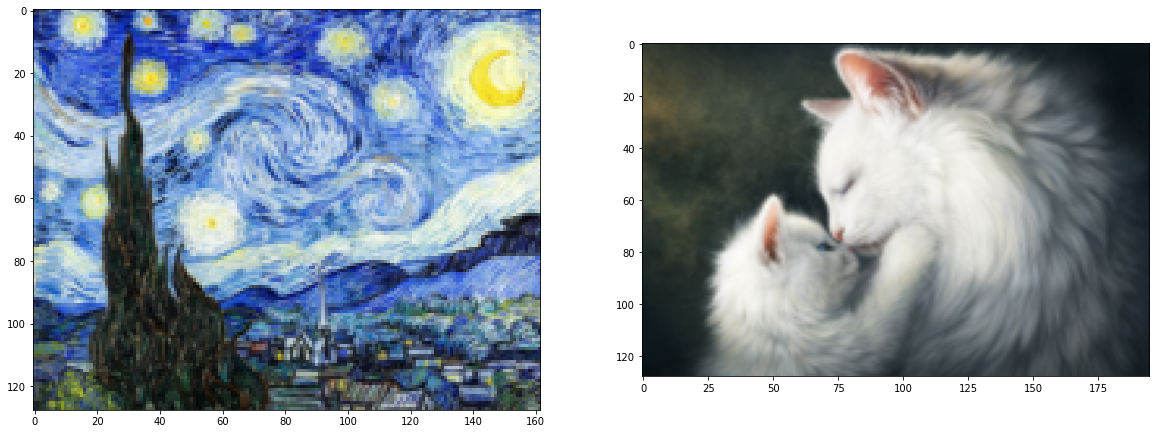

In [8]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize = (20,10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style));

In [9]:
def get_features (image, model, layers = None):
    
    if layers is None:
        layers = {'0':'conv1_1',
                 '5':'conv2_1',
                 '10':'conv3_1',
                 '19':'conv4_1',
                 '21':'conv4_2',
                 '28':'conv5_1'}
        features = {}
        x = image

        for name, layer in model._modules.items():
            x = layer(x)
            if name in layers:
                features[layers[name]] = x

        return features

### 3. Gram Matrix

In [10]:
def gram_matrix(tensor):
    _,d,h,w = tensor.size()
    tensor = tensor.view(d,h*w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [11]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

### 4. Define Losses anf Weights

In [12]:
style_weights = {'conv1_1':1,
                 'conv2_1':0.75,
                 'conv3_1':0.2,
                 'conv4_1':0.2,
                 'conv5_1':0.2}
content_weight = 1
style_weight = 1e3

### 5. Update target and calculate losses

Total loss:  3089.7880859375


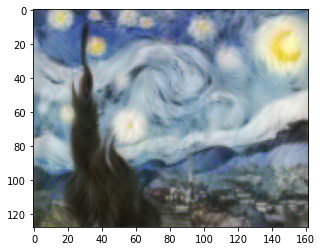

Total loss:  1258.157470703125


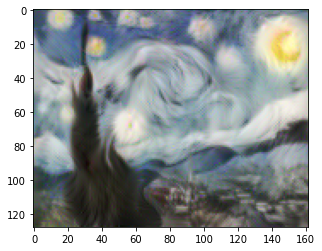

Total loss:  866.3366088867188


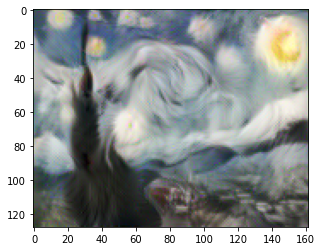

Total loss:  690.8101806640625


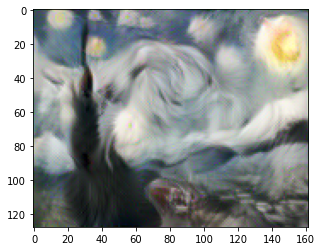

Total loss:  585.384033203125


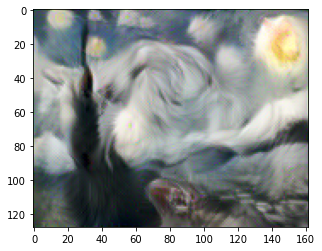

Total loss:  513.5708618164062


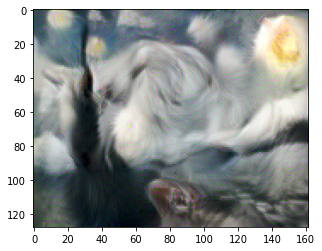

Total loss:  460.8186950683594


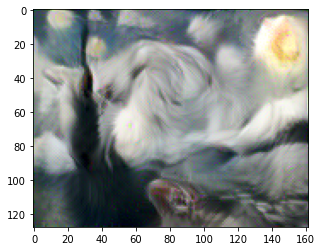

Total loss:  418.512939453125


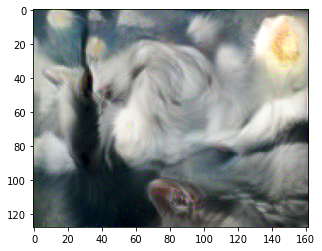

Total loss:  382.8735046386719


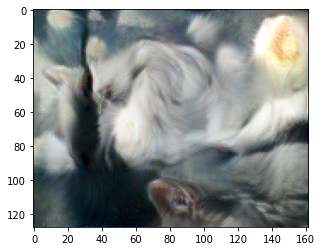

Total loss:  353.0097961425781


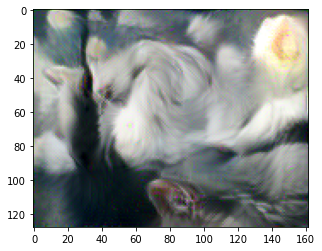

In [13]:
show_every = 500
steps = 5001
optimizer = optim.Adam([target], lr = 0.003)

for ii in range(1, steps+1):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    style_loss = 0

    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

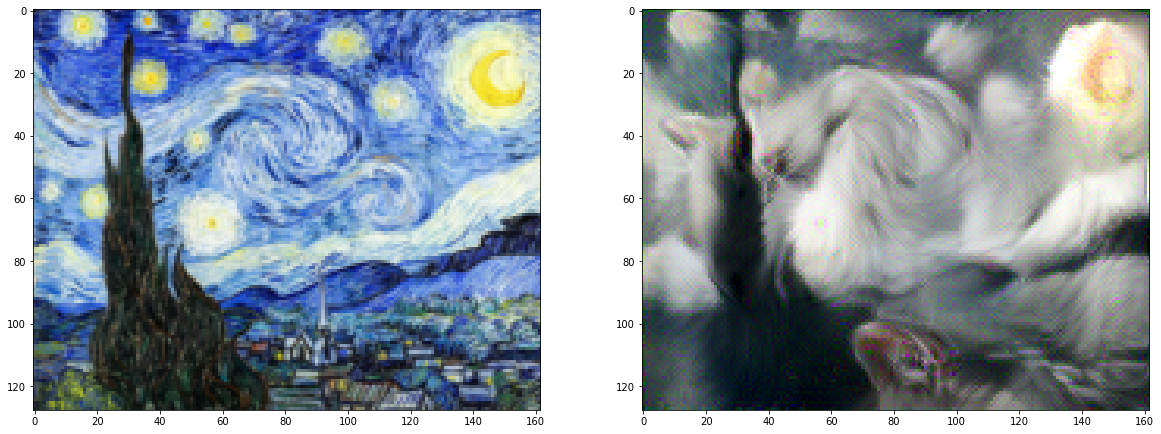

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))